### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import random
from matplotlib import pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
import torch as th
import wandb
from stable_baselines3.common.env_util import make_vec_env
import tensorboard

2024-12-20 14:23:48.936307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 14:23:49.427905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2
from environment import Environment
from resource_allocation import *

### Define Environment

In [3]:
# Use the Solarize Light style globally
plt.style.use("Solarize_Light2")

# Set global parameters for black axes, labels, and grid
plt.rcParams['grid.color'] = 'white'               # Grid color
plt.rcParams['grid.linestyle'] = '--'              # Grid linestyle
plt.rcParams['grid.alpha'] = 0.7                   # Grid transparency
plt.rcParams['axes.edgecolor'] = 'black'           # Axis border color
plt.rcParams['axes.labelcolor'] = 'black'          # Axis label color
plt.rcParams['xtick.color'] = 'black'              # X-axis tick color
plt.rcParams['ytick.color'] = 'black'              # Y-axis tick color
plt.rcParams['text.color'] = 'black'               # Default text color, affects title color

In [12]:
import gymnasium as gym  # Correct import for Gymnasium
from gymnasium import spaces
import numpy as np

class QoEEnvironment(gym.Env):
    """
    Custom environment for QoE simulation compatible with Gymnasium.
    """
    def __init__(self, run_for=5000, cpu_capacity=5.5, seed=4022, num_area = 1, optimal = False):
        super(QoEEnvironment, self).__init__()
        
        # Initialize the environment parameters
        self.run_for = run_for
        self.cpu_capacity = cpu_capacity
        self.num_area = num_area
        self.env = Environment(run_for, cpu_capacity, seed)
        self.env.run_for = run_for
        self.seed_value = seed  # Save seed for reproducibility
        self.optimal = optimal
        
        # Seed NumPy and random
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        np.random.seed(seed)  
        random.seed(self.seed_value)  # Seed Python's random        
              
        self.history_length = 30
        # Number of previous timesteps to include in the observation

        # Define action and observation spaces
        # For example, the observation includes 4 features per timestep 
        #? (QoE, users, attack intensity, CPU allocation)
        #* (QoE, users, attack intensity, L, beta_0, beta_CPU, CPU allocation)
        self.features_per_timestep = 7
        self.observation_space = spaces.Box(
            low=0, high=1, 
            # shape=(self.num_area, self.history_length, self.features_per_timestep,), 
            # shape=(self.history_length, self.num_area * self.features_per_timestep,), 
            shape=(5, self.num_area * self.features_per_timestep,), 
            # shape=(self.num_area * self.history_length * self.features_per_timestep,), 
            dtype=np.float32)
        
        self.action_space = spaces.MultiDiscrete([11]*num_area) 
        # self.action_space = spaces.Discrete(11**num_area) 
        # Initialize history
        self.history = np.zeros(
            (num_area, self.history_length, self.features_per_timestep), 
            dtype=np.float32)

        # Initialize simulation-specific variables
        self.current_timestep = 0
        
        #? Record Previous States
        self.prev_atk_state = ""
        self.prev_cpu_decision = [cpu_capacity]*num_area
        
        self.reset(seed)

    def reset(self, seed=None,):
        """
        Reset the environment to an initial state and return the initial observation.
        """
        super().reset(seed=seed)
        if seed is not None:
            self.seed_value = seed
            self.np_random, _ = gym.utils.seeding.np_random(seed)
            np.random.seed(seed)        
            random.seed(self.seed_value)
            
        self.env = Environment(self.run_for, self.cpu_capacity, seed)
        self.current_timestep = 0        
        self.env.initialize_agent(num_area=self.num_area, num_streamers=10, num_attackers=1)

        # Reset state
        self.history = np.zeros(
            (self.num_area, self.history_length, self.features_per_timestep), 
            dtype=np.float32)
        observation_reshaped = self.history.transpose(1, 0, 2).reshape(self.history_length, -1)  # (20, 4 * num_area)
        observation = np.array([
            observation_reshaped[-1],                                          # t
            observation_reshaped[-5], #if self.history_length >= 6 else None,    # t-5
            observation_reshaped[-10],# if self.history_length >= 11 else None,  # t-10
            observation_reshaped[-15],# if self.history_length >= 16 else None   # t-15
            observation_reshaped[-20],# if self.history_length >= 16 else None   # t-15
        ])
        return observation, {}        
        return self.history, {}  # Return initial observation and info

    def step(self, action):
        """
        Decide Action => Start next timestep => Get the QoE => Store it in history.
        Updates only every H timesteps.
        """
        H = 5  # Update interval
        
        # Set Default Values
        # video_cpus = [self.history[area_idx, -1, 2] * self.cpu_capacity for area_idx in range(self.num_area)]
        video_cpus = self.prev_cpu_decision
        
        if self.current_timestep%H==0:
        # if True:
            for area_idx in range(self.num_area):
                area = self.env.area_dict[area_idx]["area"]
                
                video_cpus[area_idx] = 0.5+action[area_idx]*0.5 
                
                # decoded_action = np.unravel_index(action, [11] * self.num_area)
                # video_cpus[area_idx] = 0.5+decoded_action[area_idx]*0.5 
                # video_cpus[area_idx] = 3.5
                # video_cpus[area_idx] = resource_decision_baseline({"ori_intensity": int(self.history[area_idx, -1, 0]*2000), "n_streamers": int(self.history[area_idx, -1, 1]*6)}) if self.current_timestep > 0 else video_cpus[area_idx]
                # video_cpus[area_idx] = resource_decision_optimal({"atk_type": self.prev_atk_state, "ori_intensity": int(self.history[area_idx, -1, 0]*2000), "n_streamers": int(self.history[area_idx, -1, 1]*6)}) if self.current_timestep > 0 else video_cpus[area_idx]
                
                area.server.cpu_allocated = video_cpus[area_idx]
                area.ids.cpu_allocated = 6.0 - video_cpus[area_idx]
                

        # Simulate one timestep
        if self.optimal: 
            tb_log, global_states, atk_config = self.env.start_new_timestep_controlled()    
        else:
            tb_log, global_states, atk_config = self.env.start_new_timestep() #Start New Timestep and gather new_state information
        self.prev_atk_state = atk_config.value['name'] #TODO: Change this to List
        self.current_timestep += 1
        area_qoe = self.env.calculate_qoe()
        self.prev_cpu_decision = video_cpus
        
        # Update QoE and normalize CPU decisions in states #? # new_state[2] = video_cpu/5.5; new_state[3] = self.env.qoe_list[-1]
        for area_idx in range(self.num_area):
            #Update states
            # global_states[area_idx][2] = video_cpus[area_idx] / self.cpu_capacity  # Normalize video CPU
            # global_states[area_idx][3] = area_qoe[area_idx]  # QoE for the area    
            global_states[area_idx][5] = video_cpus[area_idx] / self.cpu_capacity  # Normalize video CPU
            global_states[area_idx][6] = area_qoe[area_idx]  # QoE for the area    

            # Update history
            self.history[area_idx] = np.roll(self.history[area_idx], shift=-1, axis=0)   
            self.history[area_idx][-1] = global_states[area_idx][:]
        
        reward = self.calculate_reward(global_states[:,1], global_states[:,0]) if self.current_timestep%H ==0 else 0

        # Check if the episode is done
        done = self.current_timestep >= self.env.run_for - 1
        truncated = False  # Not using truncated episodes here

        # Additional info
        
        # for area_idx in range(self.num_area):
            # tb_log[f"Edge_Area_{area_idx}/qoe"] = area_qoe[area_idx]  # QoE for the edge area
        info = tb_log
        info["mean_qoe"] = self.env.global_qoe_list[-1]
        
        observation_reshaped = self.history.transpose(1, 0, 2).reshape(self.history_length, -1)  # (H, 4 * num_area)
        
        #* Observation every H Steps:
        observation = np.array([
            observation_reshaped[-1],                                          # t
            observation_reshaped[-5], #if self.history_length >= 6 else None,    # t-5
            observation_reshaped[-10],# if self.history_length >= 11 else None,  # t-10
            observation_reshaped[-15],# if self.history_length >= 16 else None   # t-15
            observation_reshaped[-20],# if self.history_length >= 16 else None   # t-15
        ])

        return observation, reward, done, truncated, info
        # return self.history, reward, done, truncated, info
    


    def calculate_reward(self, atk_arr, usr_arr):
        """
        Calculate the reward for the given state.
        """
        lambda_1, lambda_2 = 0.5,0.5
        beta_user, beta_atk = 0.2,0.3
        total_atk = atk_arr.sum()
        total_user = usr_arr.sum()
        if len(self.env.global_qoe_list) > 1:
            qoe = self.env.global_qoe_list[-1]
            # return self.env.global_qoe_list[-1] - self.env.global_qoe_list[-2]+0.2
            # return self.env.global_qoe_list[-1] - 0.8
            # return self.env.global_qoe_list[-1]

            # reward_defend=0
            # reward_video=0    
            # baseline_qoe = 1-beta_user*total_user - beta_atk*total_atk 
            if total_atk>0:
                reward =  qoe - 0.8 #Scaled by number of attack and user? if user is too much decrease the threshold
            else:
                qoe_diff = min(1, 10*(qoe - 0.92))
                reward = min(qoe_diff * 0.01,qoe_diff) #Scaled by number of user?   
                
            return reward
        return 0

    def render(self, mode="human"):
        """
        Render the environment (optional).
        """
        print(f"Timestep: {self.current_timestep}, State: {self.history[-1]}")

    def close(self):
        """
        Cleanup the environment (optional).
        """
        print("Environment closed.")


### CONFIG: H=5, Reward per H, History Length = 15, Faster Attack Arrival Rate, AR Process np.repeat(30)

### Check The Environment

In [13]:
import warnings
warnings.filterwarnings("ignore")

run_for = 50_000
env = QoEEnvironment(run_for=run_for, cpu_capacity=5.5, seed=4022, num_area=3)
obs, _ = env.reset(seed=4022)
# check_env(env)  # This will raise exceptions if there are API compliance issues
for timestep in range(100):
    action = env.action_space.sample()  # Sample a random action
    obs, reward, done, truncated, info = env.step(action)  # Perform the step
    if done:
        print("Episode finished!")
        break  # Exit if the episode ends

obs

array([[ 0.4       ,  0.3565    , -0.        ,  0.5       , -0.4       ,
         0.18181819,  0.24673554,  0.4       ,  0.        , -1.        ,
         1.        , -1.        ,  0.36363637,  0.71315235,  0.7       ,
         0.372     , -0.        ,  0.5       , -0.4       ,  0.27272728,
         0.47505412],
       [ 0.4       ,  0.3565    , -0.        ,  0.5       , -0.4       ,
         0.18181819,  0.24673554,  0.4       ,  0.        , -1.        ,
         1.        , -1.        ,  0.36363637,  0.71315235,  0.7       ,
         0.372     , -0.        ,  0.5       , -0.4       ,  0.27272728,
         0.47505412],
       [ 0.4       ,  0.3565    , -0.        ,  0.5       , -0.4       ,
         0.54545456,  0.945922  ,  0.4       ,  0.        , -1.        ,
         1.        , -1.        ,  1.        ,  0.99418855,  0.7       ,
         0.372     , -0.        ,  0.5       , -0.4       ,  0.6363636 ,
         0.9764087 ],
       [ 0.4       ,  0.35      , -0.        ,  0.5       

In [14]:
obs.shape

(5, 21)

### Initialize Training

In [15]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import EvalCallback
from wandb.integration.sb3 import WandbCallback

class CustomWandbCallback(WandbCallback):
    def __init__(self, gradient_save_freq=100, model_save_path=None, verbose=0):
        super().__init__(verbose)
        # self.gradient_save_freq = gradient_save_freq
        # self.model_save_path = model_save_path

    def _on_step(self) -> bool:
        # Access the environment's info dictionary
        infos = self.locals["infos"]  # List of dictionaries from env.step()

        # Log edge-specific and global metrics
        for info in infos:
            # Log edge-specific metrics
            for key, value in info.items():
                if "Edge_Area_" in key:  # Edge area-specific metrics
                    wandb.log({key: value, "step": self.num_timesteps})

            # Log global QoE
            if "mean_qoe" in info:
                wandb.log({"Global QoE": info["mean_qoe"], "step": self.num_timesteps})


        # Save model periodically
        if self.model_save_path and self.num_timesteps % self.gradient_save_freq == 0:
            self.model.save(f"{self.model_save_path}_{self.num_timesteps}")

        return True

In [16]:
# from stable_baselines3 import DQN, PPO
# from sb3_contrib import RecurrentPPO

# # from sb3_contrib import QRDQN
# # Create a profiler instance

# env=QoEEnvironment(run_for=run_for, cpu_capacity=5.5, num_area=3)
# env = Monitor(env, log_dir)

# policy_kwargs = dict(activation_fn=th.nn.ReLU,
#                      net_arch=[128, 256, 128, 64, 64])
# # Initialize the DQN agent
# model = DQN(
#     "MlpPolicy",  # Use a standard multi-layer perceptron policy
#     env,
#     learning_rate=0.001,
#     buffer_size=50000,
#     learning_starts=1000,
#     batch_size=64,
#     gamma=0.99,  # Discount factor for future rewards
#     target_update_interval=500,
#     train_freq=4,  # Train every 4 environment steps
#     verbose=1,
#     tensorboard_log="./dqn_logs/",
#     max_grad_norm=10,
#     seed=4022,
#     policy_kwargs=policy_kwargs,
# )
# # Train the agent
# model.learn(total_timesteps=1_000_000)

# # Save the trained model
# # model.save("dqn_qoe_env")


In [17]:
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
# Config dictionaries
config = {
    "project_name": "ids-project",
    "entity_name": "vincent",
    "learning_rate": 5e-4,
    "batch_size": 128,
    "gamma": 0.99,
    "n_steps": 256,
    "total_timesteps": 1_000_000,
    "run_for": 10_000,  # Example parameter for QoEEnvironment
    "cpu_capacity": 5.5,
    "num_area": 3,
    "log_dir": "./tb_logs/"
}#* 


def select_model(env, model_type="DQN"):
    policy_config = {
        "MlpLstmPolicy": {
            # "net_arch": [32, 16],
            "lstm_hidden_size": 128,
            "n_lstm_layers":2,
        },
        "PPO": {
            "net_arch": [256, 128],
        },
        "DQN": {
            "net_arch": [256, 256],
            "buffer_size": 50_000,
            "learning_starts": 1_000,
            "target_update_interval": 500,
            "train_freq": 4,
            "max_grad_norm": 10,
            "seed": 4022,
        }
    }    
    
    if model_type == "RecurrentPPO":
        model = RecurrentPPO(
            "MlpLstmPolicy",
            env,
            # learning_rate=config["learning_rate"],
            batch_size=config["batch_size"],
            n_steps=config["n_steps"],
            gamma=config["gamma"],
            verbose=1,
            tensorboard_log=config["log_dir"],
            policy_kwargs=dict(
                # net_arch=policy_config["MlpLstmPolicy"]["net_arch"],
                n_lstm_layers=2,
                lstm_hidden_size=policy_config["MlpLstmPolicy"]["lstm_hidden_size"],
            ),
            learning_rate=3e-4, 
            clip_range=0.3, 
            ent_coef=0.01, 
            max_grad_norm=0.5,             
            
            device='cuda:0' if th.cuda.is_available() else "cpu"
        )
    elif model_type == "PPO":
        model = PPO(
            "MlpPolicy",
            env,
            learning_rate=config["learning_rate"],
            batch_size=config["batch_size"],
            n_steps=config["n_steps"],
            gamma=config["gamma"],
            verbose=1,
            tensorboard_log=config["log_dir"],
            policy_kwargs=dict(
                net_arch=policy_config["PPO"]["net_arch"],
            ),
            device='cuda:0' if th.cuda.is_available() else "cpu"
        )
    elif model_type == "DQN":
        model = DQN(
            "MlpPolicy",
            env,
            learning_rate=config["learning_rate"],
            batch_size=config["batch_size"],
            gamma=config["gamma"],
            verbose=1,
            tensorboard_log=config["log_dir"],
            policy_kwargs=dict(
                net_arch=policy_config["DQN"]["net_arch"],
            ),
            buffer_size=policy_config["DQN"]["buffer_size"],
            learning_starts=policy_config["DQN"]["learning_starts"],
            target_update_interval=policy_config["DQN"]["target_update_interval"],
            train_freq=policy_config["DQN"]["train_freq"],
            max_grad_norm=policy_config["DQN"]["max_grad_norm"],
            seed=policy_config["DQN"]["seed"],
            device='cuda:0' if th.cuda.is_available() else "cpu"
        )    
    return model

In [18]:
model_type = "RecurrentPPO"

# Initialize wandb
wandb.init(
    project=config["project_name"],
    entity=config["entity_name"],
    sync_tensorboard=True,
    config=config,
    settings=wandb.Settings(init_timeout=150)
)

# Environment setup
env = QoEEnvironment(
    run_for=config["run_for"],
    cpu_capacity=config["cpu_capacity"],
    num_area=config["num_area"],
    # optimal=True
)
env = Monitor(env, config["log_dir"])


model = select_model(env, model_type)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [19]:
# Train the model with Wandb callback
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=CustomWandbCallback(
        gradient_save_freq=100,
        # model_save_path="models/{}_model".format(model_type.lower()),
    ),
)

# Finish wandb run

ValueError: could not broadcast input array from shape (30,21) into shape (5,21)

In [ ]:
wandb.finish()


Edge_Area_0/final_atk_intensity,▄▄▄▄█▄▄▄▄▄▁▄▄▄▄▃▄▄▄▄▄▂▂▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Edge_Area_0/total_users,▃▆▁▂▅████▅▂▃▃▃▃▁▃▇█▅▅▅▅█▆▅▃▅▅▅▃▅▅▁▃▇▃▅▇▃
Edge_Area_0/video_cpu,▁▅▁▁▅▁▁▁▁▁▁█▁██▁█▅▁▁▅▁▁▁█▁█▁▁▁▁▁▁▁█▁▅▁▅▅
Edge_Area_1/final_atk_intensity,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Edge_Area_1/total_users,▇▂▃▇▇▇▅▂▃█▅▃▃▂▁▁▁▆▃▂▅▃▄▆█▅▄▄█▆▄▃▄▄▇█▃▂▃▃
Edge_Area_1/video_cpu,▆▇▆▇▇█▆▁▆▇▆▇▆█▅▆▇▆▇▆▆▆▇▆▆▆▅▆▇▇▇█▇▆▇█▇▆▆▇
Edge_Area_2/final_atk_intensity,▅▅▅▅▅█▅▅▅▅▁▅▅▅▅▅▅▅▅▅▅▅▅▅▃▅▅█▆▅▅▅▅▅▅▅▅▅▅▅
Edge_Area_2/total_users,▅▂▂▄▄▅▄▇▄▁▄██▄▅▄▅▁▂▄▂▅▅▅▄█▅▇▇▇▇█▇▄▄▅▅▄█▂
Edge_Area_2/video_cpu,███▆███▆▆▆██▃██▁█▃█▃▁██▃▆█████▆█████▆▆██
Global QoE,▇▄█▇▇▄▁▇█▅██▇███▇▅▄▆███████▆▇▄▆▇▄██▆▄██▆
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇██████


In [ ]:
# # Environment setup
# env = QoEEnvironment(
#     run_for=config["run_for"],
#     cpu_capacity=config["cpu_capacity"],
#     num_area=config["num_area"],
#     optimal=True
# )
# env = Monitor(env, config["log_dir"])

In [ ]:
from stable_baselines3 import DQN

# Load the best model
best_model_path = "./gym/best_model"
# model = DQN.load(best_model_path)
n_episodes = 2  # Number of evaluation episodes
total_rewards = []
total_qoe = []
for episode in range(n_episodes):
    print(episode)
    obs, _ = env.reset(seed=4022+episode)
    done = False
    episode_reward = 0

    while not done:
        # Use the trained model to predict the action
        action, _ = model.predict(obs, deterministic=True)  # Use deterministic actions during evaluation
        try:
            obs, reward, done, truncated, info = env.step(action)
        except:
            obs, reward, done, truncated, info = env.env.step(action)
        episode_reward += reward

    total_rewards.append(episode_reward)
    try:
        total_qoe.append(np.mean(env.env.env.global_qoe_list))
    except:
        total_qoe.append(np.mean(env.env.global_qoe_list))
    print(f"Episode {episode + 1}: Total Reward = {episode_reward}")
    

# Calculate average reward over episodes
average_reward = sum(total_rewards) / n_episodes
print(f"Average Reward over {n_episodes} episodes: {average_reward}")
print(f"Average QoE over {n_episodes} episodes: {np.mean(total_qoe)}")
total_qoe

0
Episode 1: Total Reward = -143.5797402119663
1


AttributeError: 'Environment' object has no attribute 'step'

Mean QoE 0.8583727308942795


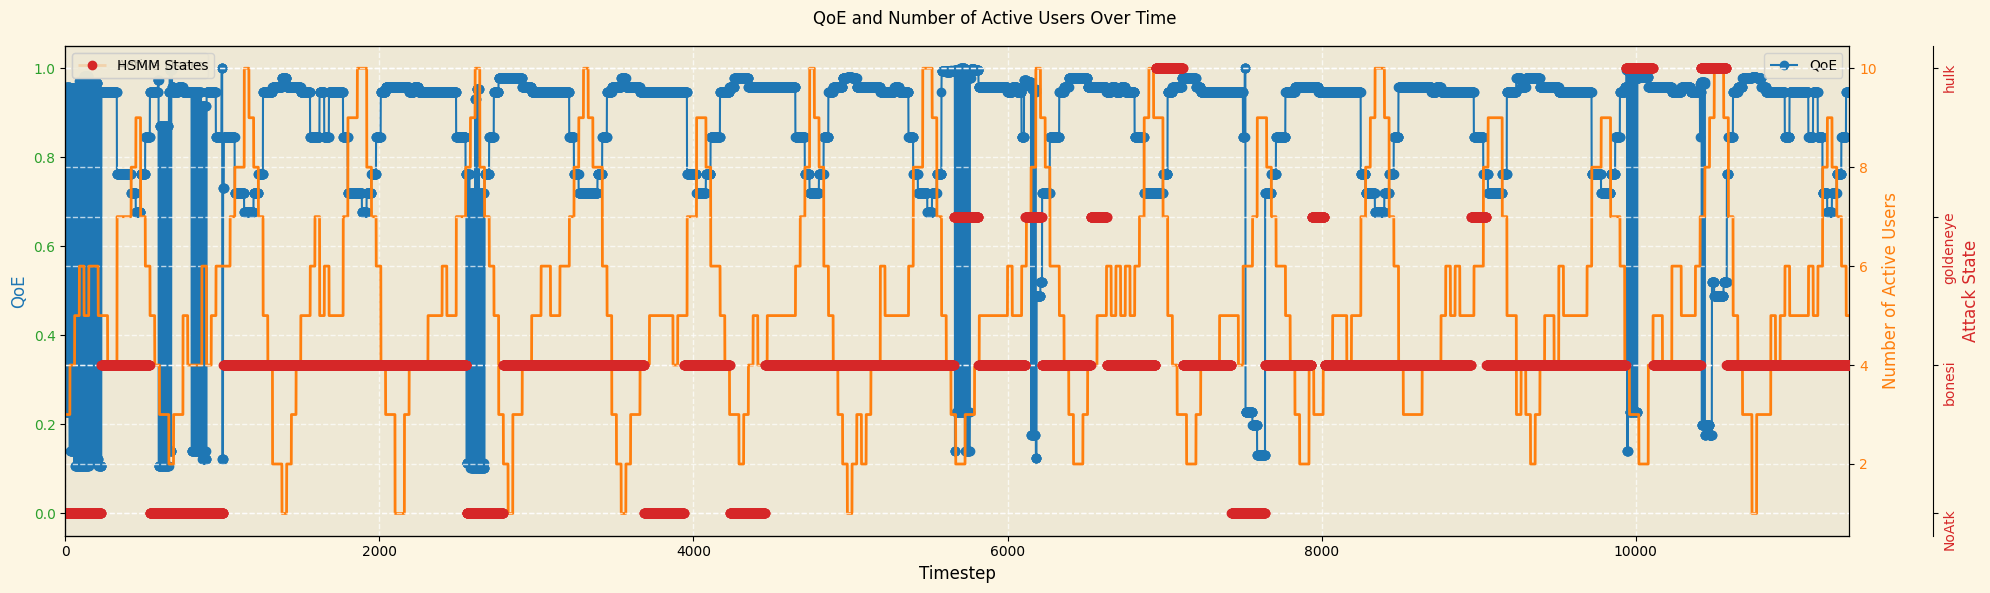

11360
Mean QoE 0.9437767923791565


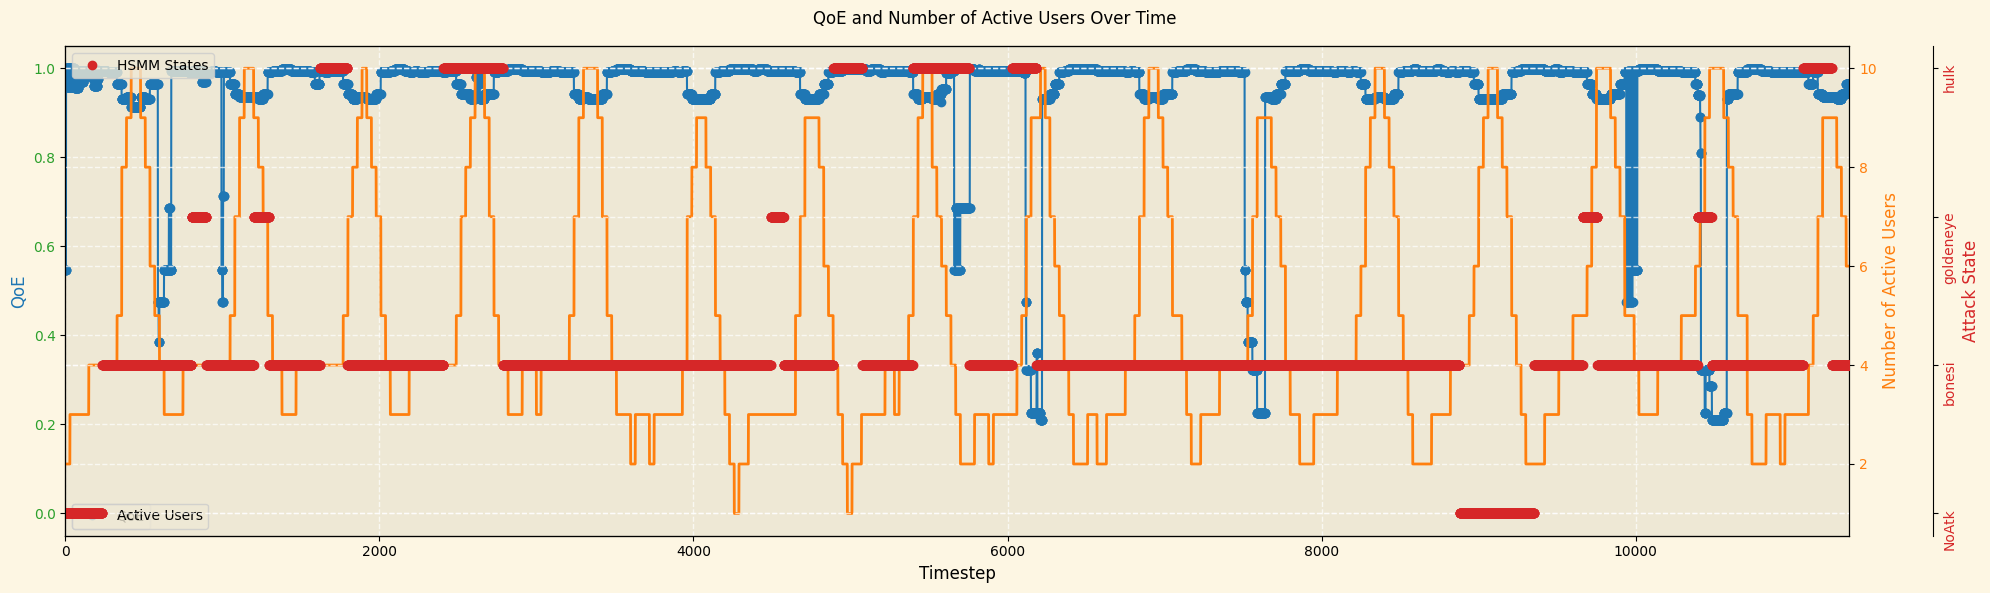

11360
Mean QoE 0.9360508787755241


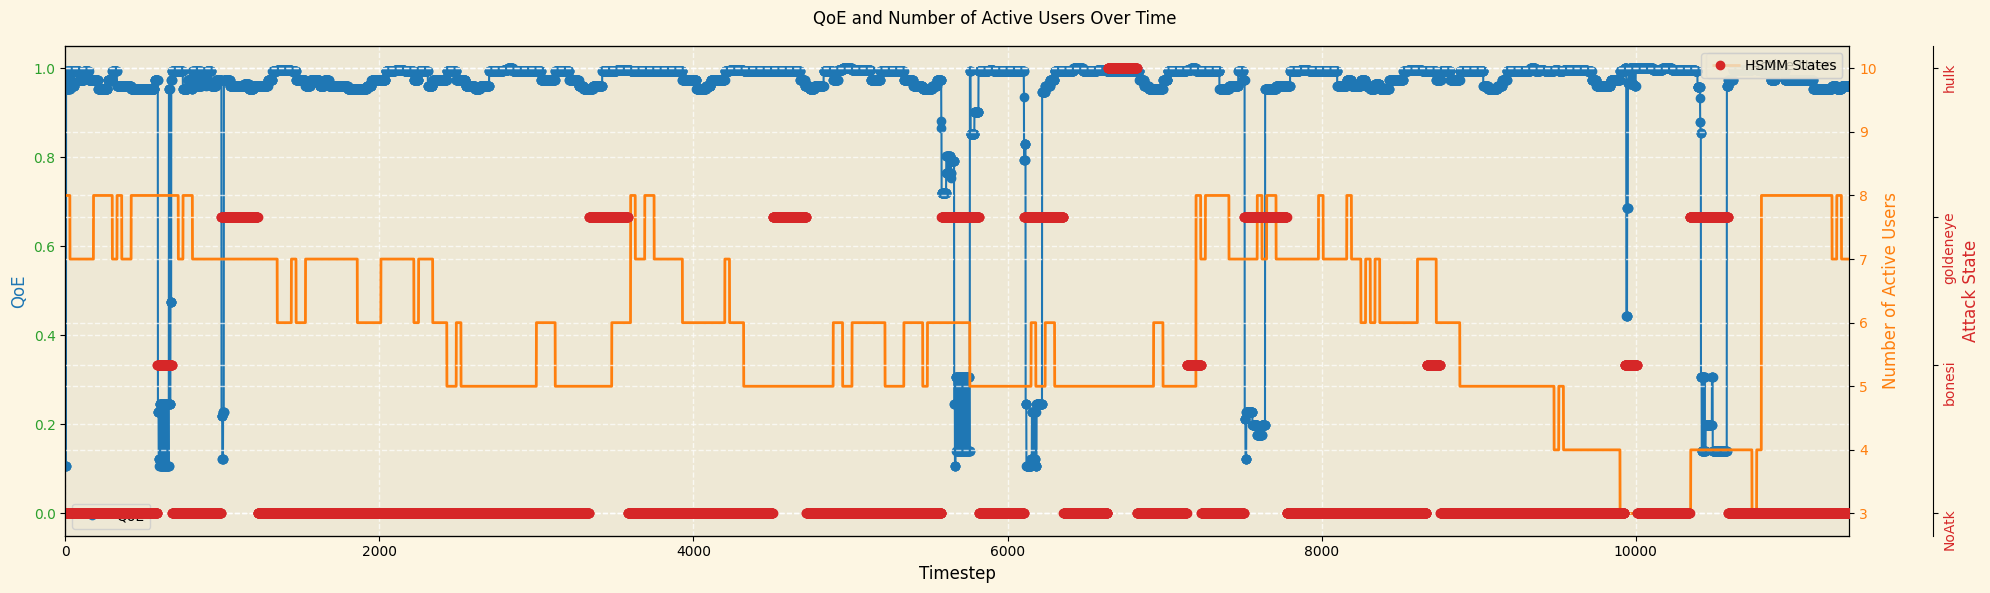

11360


In [ ]:
env.env.env.plot_qoe()

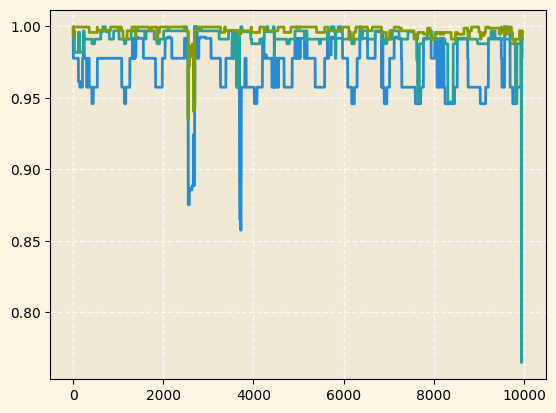

In [ ]:
for _, edge_area in env.env.env.area_dict.items():
    plt.plot(edge_area["qoe_list"])
    

In [ ]:
for i, edge_area in env.env.area_dict.items():
    server = edge_area['area'].server
    ids = edge_area['area'].ids    
    # atk_config = server.attack_config_list[0]
    print(edge_area['user_count_list'])

[3. 3. 3. ... 6. 6. 6.]
[3. 3. 3. ... 6. 6. 6.]
[5. 5. 5. ... 8. 8. 8.]


In [ ]:
env.reset()
env.env.initialize_agent(3,10,1)

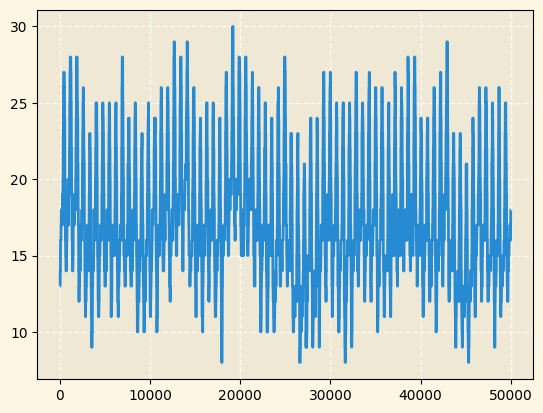

In [ ]:
plt.plot(env.env.user_count_list)